Loading Libraries

In [1]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import*
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot

import optuna
import warnings
warnings.filterwarnings('ignore')

Preparing Dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
dataset = read_csv(url, header=None)
data = dataset.values
x_data, y_data = data[:, :-1],data[:, -1]
x_data = pd.DataFrame(x_data.astype('float64'))
# Label Encoding Target
###  (M) Mines are now 1 and (R) Rocks are now 0
le = preprocessing.LabelEncoder()
le.fit(y_data)
y_data = le.transform(y_data)
y_data = pd.DataFrame(y_data.astype('float64'))

SpotOnCheck: Compare Classifier

neg_log_loss
RF: -0.528297 (0.100396)
CatB: -0.496067 (0.122141)
lgbm: -0.595345 (0.270097)
xgb: -0.657288 (0.254911)
GBC: -0.725244 (0.371779)
ADA: -0.644955 (0.035297)
LR: -0.615503 (0.210389)
SVM: -0.729842 (0.242143)
DC: -0.690984 (0.002031)


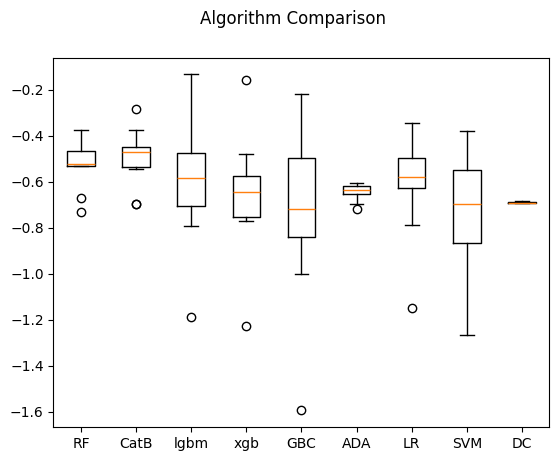

In [42]:
# append models
models = []
#models.append(('ET', ExtraTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('CatB', CatBoostClassifier(verbose=False)))
models.append(('lgbm', LGBMClassifier(verbose=-1)))
models.append(('xgb', XGBClassifier()))
#models.append(('ridge',  RidgeClassifier()))
models.append(('GBC',  GradientBoostingClassifier()))
models.append(('ADA',  AdaBoostClassifier()))
models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(probability=True)))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
#models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('DC', DummyClassifier()))
results = []
results_std = []
names = []
scoring = 'neg_log_loss'
print(scoring)
# Set Cross-Validation
kfold = StratifiedKFold(n_splits=10, random_state=None)
for name, model in models:   
    cv_results = cross_val_score(model, x_data, y_data, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #results_std.append(cv_results.std())
    mean_scoring = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(mean_scoring)
# Create a Dataframe with the results for possible later processing
#df_SpotonCheck = pd.DataFrame({'name': names, 'Logloss': results, 'Std': results_std})
# Classifier Comparision Boxplot
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Findings: SpotOnCheck  
Based on the logloss results, we will pick a few tree-based models and since logistic regression is surprisingly good, we will take that too.

SpotOnCheck Ensembles

>CatB -0.317 (0.062)
>lgbm -0.307 (0.130)
>xgb -0.346 (0.133)
>GBC -0.393 (0.158)
>stacking -0.402 (0.043)
>soft_voting -0.301 (0.091)


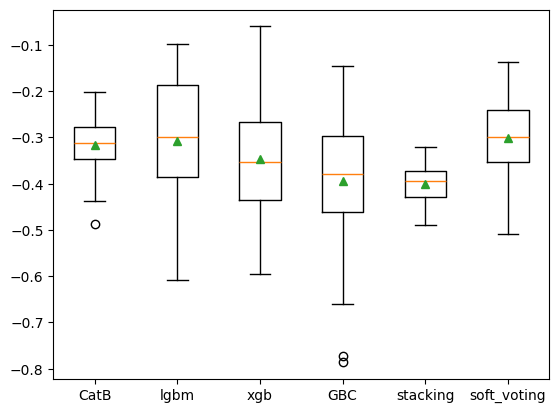

In [48]:

# defining stacking model
def get_stacking():
    # base models
    level0 = list()
    level0.append(('CatB', CatBoostClassifier(verbose=False)))
    level0.append(('lgbm', LGBMClassifier(verbose=-1)))
    level0.append(('xgb', XGBClassifier()))
    level0.append(('GBC', GradientBoostingClassifier()))
    # level1 model
    level1 = LogisticRegression()
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

def get_voting_soft():
    # base models
    models = list()
    models.append(('CatB', CatBoostClassifier(verbose=False)))
    models.append(('lgbm', LGBMClassifier(verbose=-1)))
    models.append(('xgb', XGBClassifier()))
    models.append(('GBC',  GradientBoostingClassifier()))
    ensemble = VotingClassifier(estimators=models, voting='soft')
    return ensemble
# models for evaluation
def get_models():
    models = dict()
    models['CatB'] = CatBoostClassifier(verbose=False)
    models['lgbm'] = LGBMClassifier(verbose=-1)
    models['xgb'] = XGBClassifier()
    models['GBC'] = GradientBoostingClassifier()
    models['stacking'] = get_stacking()
    models['soft_voting'] = get_voting_soft()
    return models

# Cross-Validation of each model
def evaluate_model(model, x_data, y_data):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x_data, y_data, scoring='neg_log_loss', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get models
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, x_data, y_data)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# compare models in boxplot
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()


# Hyperparameter Tuning

### Catboost Hyperparameter Tuning

### XGBoost Hyperparameter Tuning

In [11]:
def objective(trial):
    #Define Hyperparameter Search Space
    params_optuna = {
        "objective" : "binary:logistic",
        "tree_method" : "gpu_hist",
        "n_estimators" : trial.suggest_int("n_estimators", 50, 1000),
        "max_depth" : trial.suggest_int("max_depth", 3, 19),
        "max_leaves" : trial.suggest_int("max_leaves", 15, 149),
        "grow_policy" : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "learning_rate" : trial.suggest_float("learning_rate", 0, 1),
        "booster" : trial.suggest_categorical("booster", ["gbtree"]),
        "reg_alpha" : trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda" : trial.suggest_float("reg_lambda", 0, 1),
        "gamma" : trial.suggest_float("gamma", 0, 10),
        "min_child_weight" : trial.suggest_float("min_child_weight", 0, 20),
        "subsample" : trial.suggest_float("subsample", 0.5, 0.9)
    }
    
    #KFold
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = []
    for train_index,test_index in skf.split(x_data,y_data):
        X_train, y_train = x_data.iloc[train_index],y_data.iloc[train_index]
        X_val, y_val = x_data.iloc[test_index],y_data.iloc[test_index]
    
        classifier = XGBClassifier(**params_optuna)
        classifier.fit(X_train, y_train)
    
        y_pred = classifier.predict_proba(X_val)
        score = log_loss(y_val, y_pred)
        scores.append(score)
    
    return np.mean(scores)
study = optuna.create_study(study_name="XGB_KFold", direction="minimize")
study.optimize(objective, n_trials=100)
study_df = study.trials_dataframe()


[I 2024-03-09 23:46:30,226] A new study created in memory with name: XGB_KFold
[I 2024-03-09 23:46:32,030] Trial 0 finished with value: 0.6219332540228626 and parameters: {'n_estimators': 154, 'max_depth': 14, 'max_leaves': 60, 'grow_policy': 'depthwise', 'learning_rate': 0.8349114466695032, 'booster': 'gbtree', 'reg_alpha': 0.19006748452292188, 'reg_lambda': 0.8877783217019768, 'gamma': 3.6701291537503797, 'min_child_weight': 1.5312386654740173, 'subsample': 0.5197545471980487}. Best is trial 0 with value: 0.6219332540228626.
[I 2024-03-09 23:46:38,265] Trial 1 finished with value: 0.6450979811275944 and parameters: {'n_estimators': 725, 'max_depth': 6, 'max_leaves': 56, 'grow_policy': 'lossguide', 'learning_rate': 0.9130555784334249, 'booster': 'gbtree', 'reg_alpha': 0.6195277829909305, 'reg_lambda': 0.8104604691348896, 'gamma': 1.672618090251654, 'min_child_weight': 12.5178692410035, 'subsample': 0.6197317748881469}. Best is trial 0 with value: 0.6219332540228626.
[I 2024-03-09 23:4

In [13]:
print(study.best_value)
print(study.best_params)
xgb_params = study.best_params

0.321625786032412
{'n_estimators': 407, 'max_depth': 9, 'max_leaves': 25, 'grow_policy': 'depthwise', 'learning_rate': 0.1072200777974355, 'booster': 'gbtree', 'reg_alpha': 0.9258303983713072, 'reg_lambda': 0.474689702514572, 'gamma': 0.008239394279134726, 'min_child_weight': 0.7176154253572017, 'subsample': 0.6710842045614129}


### GBC Hyperparameter Tuning

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
def objective(trial):
    #Define Hyperparameter Search Space
    params_optuna = {
        "learning_rate" : trial.suggest_float("learning_rate", 0, 1),
        "n_estimators" : trial.suggest_int("n_estimators", 50, 1000),
        "subsample" : trial.suggest_float("subsample", 0, 1),
        "criterion" :  trial.suggest_categorical("criterion", ["friedman_mse", "squared_error"]),
        "min_samples_split" : trial.suggest_float("min_samples_split", 0, 1),
        "min_samples_leaf" : trial.suggest_float("min_samples_leaf", 0, 1),
        "max_depth" : trial.suggest_int("max_depth", 3, 50),
        "min_impurity_decrease" : trial.suggest_float("min_impurity_decrease", 0, 1)
    }
    
    #KFold
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = []
    for train_index,test_index in skf.split(x_data,y_data):
        X_train, y_train = x_data.iloc[train_index],y_data.iloc[train_index]
        X_val, y_val = x_data.iloc[test_index],y_data.iloc[test_index]
    
        classifier = GradientBoostingClassifier(**params_optuna)
        classifier.fit(X_train, y_train.values.ravel())
    
        y_pred = classifier.predict_proba(X_val)
        X_train_pred = classifier.predict_proba(X_train)[:,1]
        
        score = log_loss(y_val, y_pred.astype(np.float64))
        scores.append(score)
    return np.mean(scores)
study = optuna.create_study(study_name="GBC_SKFold", direction="minimize")
study.optimize(objective, n_trials=10)
study_df = study.trials_dataframe()


In [ ]:
print(study.best_value)
print(study.best_params)

### LGB Hyperparamter Tuning

In [ ]:
x_data_lgb = x_data.to_numpy()
y_data_lgb = y_data.to_numpy()

def objective(trial):
    params = {
        'device' : 'gpu',
        'objective': 'softmax',
        'metric': 'log_loss',
        'num_class': 7,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 12),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    # Perform k-fold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, valid_idx in kf.split(x_data_lgb, y_data_lgb):
        dtrain = lgb.Dataset(x_data_lgb[train_idx], label=y_data_lgb[train_idx])
        dvalid = lgb.Dataset(x_data_lgb[valid_idx], label=y_data_lgb[valid_idx])
        model = lgb.train(params, dtrain, valid_sets=[dvalid], num_boost_round=50)
        valid_pred = model.predict(x_data_lgb[valid_idx])
        score = log_loss(y_data_lgb[valid_idx], valid_pred)
        scores.append(score)
    return np.mean(scores)
study = optuna.create_study(direction='minimize')
# Suppress INFO logs by setting the logging level to WARNING
#optuna.logging.set_verbosity(optuna.logging.ERROR)
study.optimize(objective, n_trials=2)
# Access the best hyperparameters and corresponding log loss
best_params = study.best_params
best_log_loss = study.best_value
study_df = study.trials_dataframe()
print(best_params)
print(best_log_loss)

# SpotOnCheck Ensembles with tuned Hyperparameters